# Visualised: How SARS-CoV-2 compares to other infectious diseases
## LUH ZQS Data Literacy Seminar, March 7, 2022

In this exercise we use a few data sources to compare SARS-CoV-2 to other infectious diseases using basic data processing and visualization using Python. The exercise is inspired by a 2014 [The Guardian visualization](https://www.theguardian.com/news/datablog/ng-interactive/2014/oct/15/visualised-how-ebola-compares-to-other-infectious-diseases) that compared Ebola with other infectious diseases.

The data sources include:
* The Microbe Scope data published by The Guardian available at [bit.ly/KIB_Microbescope](https://bit.ly/KIB_Microbescope). A copy of this dataset is included (see `data.csv`).
* [ORKG](https://orkg.org) Comparisons for SARS-CoV-2 [basic reproductive rate](https://www.orkg.org/orkg/comparison/R44930) and [case fatality rate](https://www.orkg.org/orkg/comparison/R41466)

To make this exercise interactive and fun, you'll need to fill the occasional `[BLANKS]` in the code before you can execute it.

Let's get started ...

First we need to import a few libraries we will need in our code

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from orkg import ORKG

Now let's read the Microbe Scope `data.csv` and get its shape, i.e. the number of rows and columns.

In [2]:
df_microbe_scope = pd.read_csv('data.csv', skiprows=[1]) # Replace [FILENAME] accordingly
df_microbe_scope.shape

(42, 40)

... and take a look at the data.

In [3]:
df_microbe_scope.head(3)

,Unnamed: 0,case fatality rate,average basic reproductive rate,primary mode of transmission,survival time on surfaces,"survival in ideal conditions (ie. blood, faeces)",note,pathogen type,infectious dose,average incubation period,...,yearly fatalities.4,http://www.who.int/healthinfo/global_burden_disease/estimates/en/index1.html,http://www.cdc.gov/mmwr/PDF/wk/mm6153.pdf,http://en.wikipedia.org/wiki/Human_mortality_from_H5N1,"individual links given in hidden columns to right, where different",Unnamed: 35,Unnamed: 36,infectious dose.1,Unnamed: 38,Unnamed: 39
0,Anthrax (untreated),20.0,6.5,airborne,NaN,70 years!,NaN,bacterium,"100,000",NaN,...,https://www.ll.mit.edu/publications/journal/pd...,NaN,NaN,NaN,NaN,NaN,NaN,http://en.wikipedia.org/wiki/Infectious_dose,NaN,NaN
1,Bird Flu (H5N1),60.0,1.0,airborne droplet,2.0,35,NaN,virus,unknown,NaN,...,http://www.phac-aspc.gc.ca/lab-bio/res/psds-ft...,http://www.nature.com/srep/2013/130710/srep021...,NaN,NaN,NaN,NaN,NaN,https://microbewiki.kenyon.edu/index.php/H5N1_...,NaN,NaN
2,Bubonic Plague (untreated),60.0,1.0,bites,3.0,100,human blood,bacterium,100,NaN,...,http://www.plosone.org/article/info%3Adoi%2F10...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.cdc.gov/biosafety/publications/bmbl...,NaN,NaN


Of particular interest are the first three columns including the disease name, the case fatality rate and the average basic reproductive rate. 

Let's select and rename them. 

Take a look at the shape and explain what happenend: Why is the second number different compared to before?

In [4]:
df_microbe_scope = df_microbe_scope.iloc[:, 0:3] # Replace [FROM_COLUMN] and [TO_COLUMN]; Hint: index starts with zero and the ending index is excluded
df_microbe_scope.columns = ['disease', 'case_fatality_rate', 'basic_reproductive_rate']
df_microbe_scope.shape

(42, 3)

In [5]:
df_microbe_scope.head(3)

,disease,case_fatality_rate,basic_reproductive_rate
0,Anthrax (untreated),20.0,6.5
1,Bird Flu (H5N1),60.0,1.0
2,Bubonic Plague (untreated),60.0,1.0


Next, we compute some descriptive statistics for case fatality and basic reproductive rates.

Let's do mean and max case fatality rate first.

In [6]:
df_microbe_scope['case_fatality_rate'].mean()

17.920238095238094

In [7]:
df_microbe_scope['case_fatality_rate'].max()

100.0

Now try the same for basic reproductive rate.

The following is a shorthand for descriptive statistics.

Try it for both basic reproductive and case fatality rates and compare the values. They should be same.

In [8]:
df_microbe_scope['case_fatality_rate'].describe()

count     42.000000
mean      17.920238
std       27.952920
min        0.000000
25%        0.350000
50%        2.300000
75%       21.500000
max      100.000000
Name: case_fatality_rate, dtype: float64

Next, let's plot the data and use visualizations to understand it better.

Try this for both basic reproductive and case fatality rates.

<AxesSubplot:ylabel='disease'>

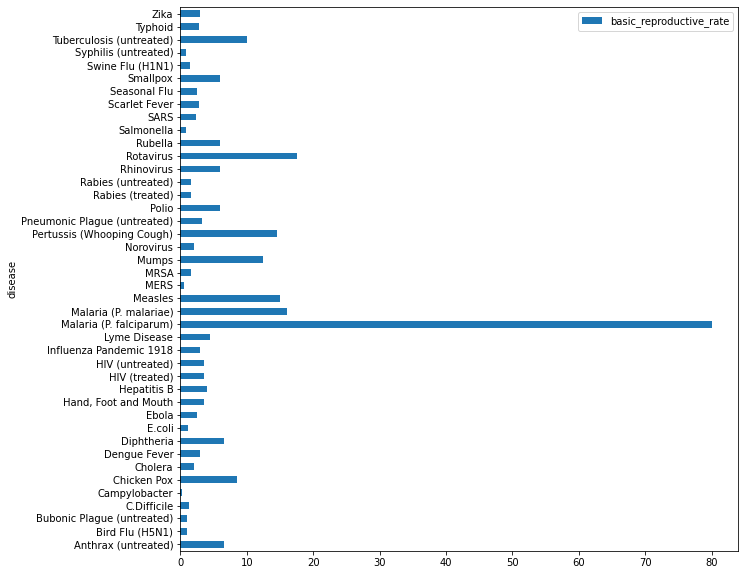

In [9]:
df_microbe_scope.plot(kind='barh', x='disease', y='basic_reproductive_rate', figsize=(10,10))

That's great, but sorted would be better to quickly see the top three and how they compare to the bottom three.

<AxesSubplot:ylabel='disease'>

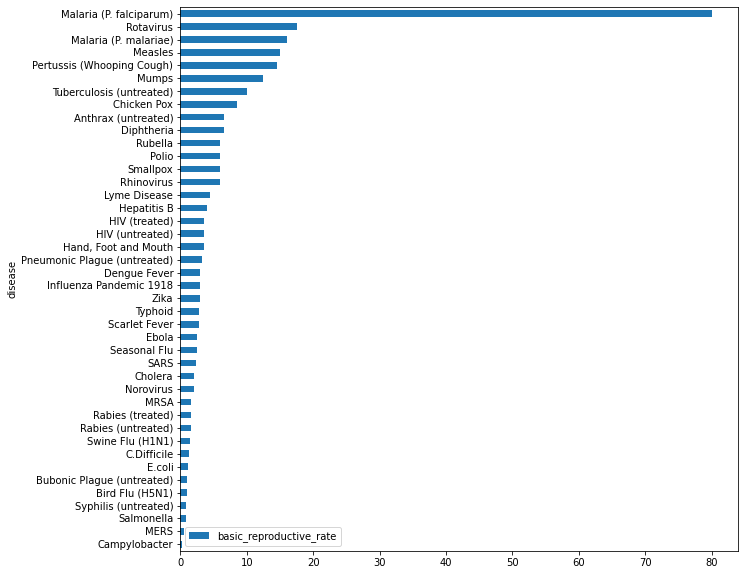

In [10]:
df_microbe_scope.sort_values(by='basic_reproductive_rate').plot(kind='barh', x='disease', y='basic_reproductive_rate', figsize=(10,10))

The disease data is not univariate but multivariante, for each disease with have two variables (the two rates). 

It makes thus sense to visualize the diseases along both dimensions, using a scatter plot.

With this we can easily identify a few characteristics:
* Most diseases cluster in the lower left corner, meaning that most diseases tend to be on the lower ends of case fatality and basic reproduction
* A few diseases are exceptional with respect to one dimension, either very high case fatality or very high basic reproduction
* No disease has both high case fatality and basic reproduction

Hint: With the additional parameters `logy=True` and `loglog=True` you can modify the axes to log scaling.

So far we have only inspected the Microbe Scope dataset, which does not include SARS-CoV-2.

The ORKG provides data extracted from the scholarly literature for SARS-CoV-2 basic reproductive rate and case fatality rate.

Take a look at the two ORKG comparisons:
* SARS-CoV-2 [basic reproductive rate](https://www.orkg.org/orkg/comparison/R44930)
* SARS-CoV-2 [case fatality rate](https://www.orkg.org/orkg/comparison/R41466)

Both comparisons include numerous published articles, each with information about these rates (see the `has value` property in the comparisons).

Let's load the two comparisons into data frames. The basic reproductive rate comparison has ID R44930 while the case fatality rate has ID R41466 (see the URL of the comparisons in the browser). We need these to load the corresponding data.

First, let's connect to ORKG.

In [11]:
orkg = ORKG(host='https://orkg.org/orkg', simcomp_host='https://orkg.org/orkg/simcomp')

Let's retrieve the data for the basic reproductive rate comparison first.

In [65]:
df_orkg_basic_reproductive_rate = orkg.contributions.compare_dataframe(comparison_id='R44930')

Now we do the same for the case fatality rate comparison.

In [102]:
df_orkg_case_fatality_rate = orkg.contributions.compare_dataframe(comparison_id='R41466') # Replace [ID] accordingly

Use the following code cell to take a look at this data. Where are the titles of the compared articles and can you find the `Has value` property?

,"The early phase of the COVID-19 outbreak in Lombardy, Italy/Contribution 1",Transmission potential of COVID-19 in Iran/Contribution 1,Transmission potential of COVID-19 in Iran/Contribution 2,Estimating the generation interval for COVID-19 based on symptom onset data/Contribution 1,Estimating the generation interval for COVID-19 based on symptom onset data/Contribution 2,Estimating the generation interval for COVID-19 based on symptom onset data/Contribution 3,Estimating the Unreported Number of Novel Coronavirus (2019-nCoV) Cases in China in the First Half of January 2020: A Data-Driven Modelling Analysis of the Early Outbreak/Contribution 1,Estimation of the Transmission Risk of the 2019-nCoV and Its Implication for Public Health Interventions/Contribution 1,Estimation of the epidemic properties of the 2019 novel coronavirus: A mathematical modeling study/Contribution 1,Estimation of the epidemic properties of the 2019 novel coronavirus: A mathematical modeling study/Contribution 2,...,Time-varying transmission dynamics of Novel Coronavirus Pneumonia in China/Contribution 1,Time-varying transmission dynamics of Novel Coronavirus Pneumonia in China/Contribution 2,Estimating the effective reproduction number of the 2019-nCoV in China/Contribution 1,Real-Time Estimation of the Risk of Death from Novel Coronavirus (COVID-19) Infection: Inference Using Exported Cases/Contribution 1,Real-Time Estimation of the Risk of Death from Novel Coronavirus (COVID-19) Infection: Inference Using Exported Cases/Contribution 2,"Early Transmission Dynamics in Wuhan, China, of Novel Coronavirus–Infected Pneumonia/Contribution 1",Pattern of early human-to-human transmission of Wuhan 2019-nCoV/Contribution 1,"Report 3: Transmissibility of 2019-nCoV. 2020. WHO Collaborating Centre for Infectious Disease Modelling, MRC Centre for Global Infectious Disease Analysis/Contribution 1",Transmission interval estimates suggest pre-symptomatic spread of COVID-19/Contribution 1,Transmission interval estimates suggest pre-symptomatic spread of COVID-19/Contribution 2
Has value,3.1,3.6,3.58,1.27,1.25,1.59,2.56,6.47,4.38,3.41,...,2.9,2.92,4.08,2.1,3.2,2.2,2.2,2.5,1.97,1.87
Method,,generalized growth model,based on the calculation of the epidemic's dou...,generation interval,serial interval,generation interval,Modelled the epidemic curve of 2019-nCoV cases...,Model-based method for estimation,"a weighted average of Exponential growth, Maxi...","a weighted average of Exponential growth, Maxi...",...,"Statistical exponential Growth, using SARS gen...","Statistical maximum likelihood estimation, usi...",Mathematical model including compartments Susc...,,,Statistical exponential growth model,Stochastic simulations of early outbreak traje...,"Mathematical model, computational modelling of...",,
Time period,Time interval,Time interval,Time interval,Time interval,Time interval,Time interval,Time interval,Time interval,Time interval,Time interval,...,Time interval,Time interval,Time interval,Time interval,Time interval,Time interval,Time interval,Time interval,Time interval,Time Interval


Now, what we actually want is the mean estimates for SARS-CoV-2 basic reproductive rate and case fatality rate as published by the numerous articles. That's easy to compute, right? 

Try to understand what is going on in the following line of code.

In [101]:
orkg_basic_reproductive_rate = np.mean(df_orkg_basic_reproductive_rate.loc['Has value', :].to_numpy(dtype=np.float32))

orkg_basic_reproductive_rate

3.020645

... and do the same for case fatality rate, which is a bit more involved because for some articles the property `Has value` has two values.

In [103]:
df = df_orkg_case_fatality_rate.T
df = df.iloc[:, 0:1]
df['Has value'] = df['Has value'].str.extract("(\d+(?:\.\d+)?)", expand=True)
df['Has value'] = pd.to_numeric(df['Has value'], errors='coerce')
orkg_case_fatality_rate = df['Has value'].mean()

orkg_case_fatality_rate

4.559090909090909